<a href="https://colab.research.google.com/github/KOFIYEB/Blogging_with_AI_Text_Image_Generation/blob/main/Mistral7B_fined_tuned_fitness_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FINE- TUNING MISTRAL 7B FOR A BLOG POST**

---



This project is particular to the fitness domain. To fine-tune a more capable** Mistral 7B** without encountering out-of-memory (OOM) errors on limited-capacity hardware, we loaded the large model, **Mistral 7B**, in 4  using bitsandbytes. More importantly, the QLoRA method was employed using the PEFT library from Hugging Face. This innovative technique updates only the essential low-rank approximations instead of the entire weight matrix, minimizing the memory requirements and enabling the use of less powerful GPUs for the fine-tuning process.

The entire project was done on Google Collab Pro using the A100 GPU for less than 40 Euros





# **Loading packages and setting up the environment**

To avoid UTF-8 errors when using the notebook for the project, the environment needs to be set up first. Also, restart the kennel after the "accelerate -U" installation pip to avoid further errors.

In [ ]:
%env LC_ALL=en_US.UTF-8
%env LC_CTYPE=en_US.UTF-8
%env LANG=en_US.UTF-8


In [ ]:
!pip install accelerate -U
!pip install transformers
!pip install diffusers["torch"]
!pip install diffusers --upgrade
!pip install -q wandb -U

In [ ]:
pip install fastapi kaleido python-multipart uvicorn

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

In [ ]:
from datasets import load_dataset
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from google.colab import drive
from peft import PeftModel

In [ ]:
import wandb, os
import torch
import matplotlib.pyplot as plt
import transformers
import shutil

# **Loading data**

No preprocessing was actually required here since data was manually compiled into three columns: **main topic, sub-topic, and content**. A fourth column was also added, namely **'combined'**, to account for missing values if any in the main topic and sub-topic by combining them.

The data was categorically collected in this manner for the purpose of our study. The intention is to generate content for the main- topic and sub-topic that are fed into the prompt. Not to confuse the AI, it makes it easier to collect data in such a structure for the purpose of this project. However, one can use traditional input and output like  ;

{"input": "Where is Ghana?", "output": "Ghana is in West Africa"}

{"input": "What is the capital of Ghana?", "output": "Accra is the capital of Ghana"}

In [ ]:
# data source
#https://www.acefitness.org/resources/pros/expert-articles/
#https://www.healthline.com/fitness
#https://www.bornfitness.com/category/fitness/

In [ ]:
train_dataset = load_dataset('json', data_files='train_set.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='test_set.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

### **Accelerator**

Step up an accelerator for training huge models on larger batch sizes, we can use a fully sharded data parallel model. This type of data parallel paradigm enables fitting more data and larger models by sharding the optimizer states, gradients, and parameters. It not entiely clear if this is needed for QLora but certainly has no adverse effect on the model.

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Weights & Biases can be used to track our training metrics and system performance. The API can be applied for when prompted which is free and highly recommended when working on such models

In [ ]:
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Currently logged in as: yeboah-amoabeng (yeboah). Use `wandb login --relogin` to force relogin


### **Formatting prompts**

we then create a **formatting_func** as prompt to test drive the base model

In [ ]:
def formatting_func(example):
    text = f"### Write me a blog post about this topic: {example['content']}"
    return text

Even though I am running the whole project in Google Collab Pro with an A100 GPU, I still deem it necessary to set up my device.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### **Load Base Model**

we now load the based model, **Mistral-7B-v0.1** ,using 4-bit quantization.

In [ ]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

### **Tokenization**

To analyze the distribution of data lengths and optimize memory usage during training, it's essential to first tokenize your dataset without applying truncation or padding. This initial step allows you to understand the length distribution of your data. Once you have this distribution, you can set an appropriate **"model_max_length" **for your tokenizer. This value should be chosen based on the length distribution to efficiently handle the majority of your data without excessive padding or truncation.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

**Reformat the prompt and tokenize each sample.** To prepare your data for processing, begin by reformatting each sentence in the dataset. Following this, tokenize each reformatted sample. This approach involves two key steps: first, adjust the structure or format of each sentence to ensure consistency and suitability for your specific task; second, apply a tokenizer to each of these reformatted sentences. This process transforms your textual data into a format that is compatible with machine learning models, facilitating effective analysis or training.

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Visualizing the length of the data

1890


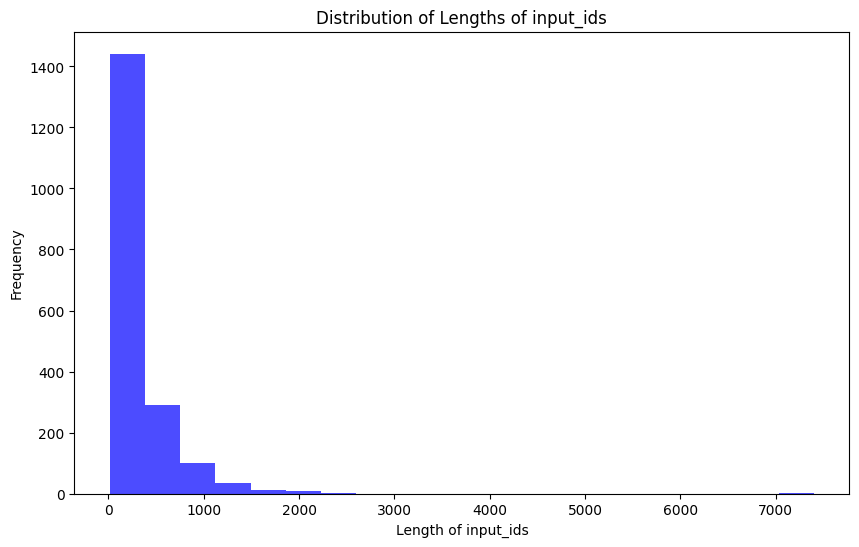

In [ ]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

The histogram of token lengths underscores the necessity of choosing an optimal max_length for our input tensors, which will be a balance between preserving information and computational efficiency. Given the skewed distribution towards shorter lengths, a judicious max_length can be selected that minimizes truncation while accommodating the majority of the data, thus ensuring minimal loss of content. This approach is reinforced by the careful preprocessing of the dataset, where samples were standardized in length by segmenting longer texts, with special care taken to not disrupt word or sentence integrity, thus facilitating a more efficient and coherent training process.

For self-supervised fine-tuning, let's proceed with tokenization by applying both padding and truncation. This step ensures uniformity in token length across all samples. Additionally, configure the tokenization function to generate identical 'input_ids' and 'labels'. In self-supervised learning, this approach is common as it enables the model to predict the next token in a sequence or reconstruct the input, using its own outputs as training targets. This method of tokenization is a key component in preparing your data for self-supervised fine-tuning.

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Ensure that in your tokenization setup, input_ids are left-padded with the eos_token (typically denoted as 2), and also include an eos_token at the end of each sequence. Additionally, each sequence should begin with a bos_token (commonly represented as 1). This structure is crucial for maintaining consistency in sequence representation, where the bos_token marks the beginning, and eos_token signifies both padding and the end of the sequence. This setup is essential for training models effectively, particularly in language modeling tasks.

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 774, 12018, 528, 264, 6073, 1704, 684, 456, 9067, 28747, 23859, 272, 23966, 11317, 28725, 396, 330, 2554, 12089, 1799, 5926, 401, 7173, 560, 8621, 354, 5597, 28705, 28770, 28782, 1267, 304, 272, 18291, 304, 7162, 302, 401, 7173, 20114, 28725, 396, 5362, 304, 7731, 5403, 2496, 354, 2528, 14417, 28725, 17950, 18015, 28725, 21726, 1651, 1362, 280

 visualization after applying padding and truncation

1890


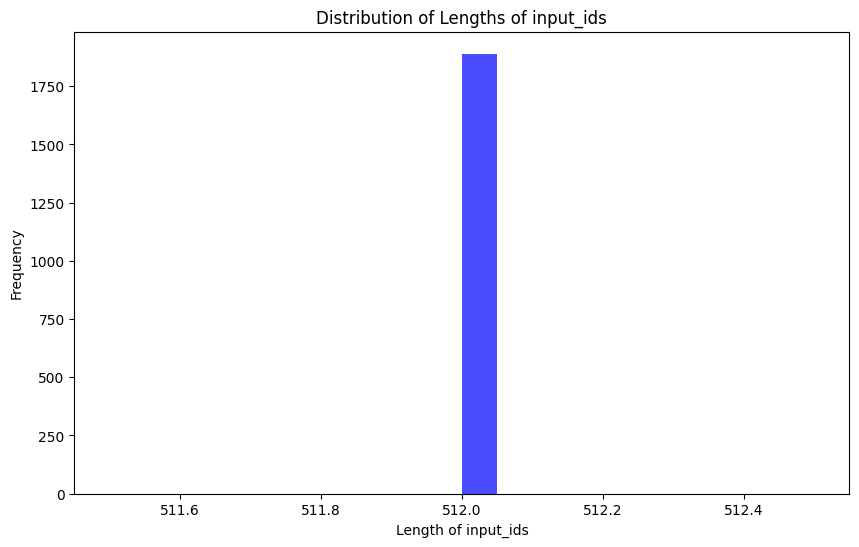

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

After applying padding and truncation, all samples in your dataset should have a uniform length, specifically equal to max_length. This ensures consistency across the dataset, which is crucial for efficient processing and training in machine learning models, especially in language-related tasks. Uniform length is achieved by truncating longer samples and padding shorter ones to match the specified max_length.

## **How does the base model do?**

Not particularly required but also necessary to test drive the model to check it initial performance.

In [ ]:
eval_prompt = " Write me a blog post about this topic: Fitness tips "

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Write me a blog post about this topic: Fitness tips 101

I’m not sure if you know, but I am a fitness instructor. I teach classes at the gym and I also have my own personal training business. I love helping people get fit and healthy! In this article, I will give you some of my best fitness tips for beginners. These are things that I tell all of my clients when they first start working with me. If you follow these simple steps, you will be on your way to reaching your fitness goals in no time!

## What is fitness?

Fitness is the ability to do physical activity without being exhausted or injured. It includes endurance, strength, flexibility and balance. The more fit you are, the easier it will be for you to do everyday activities like walking up stairs or carrying groceries into your house. Being physically active can help prevent many diseases such as heart disease, diabetes and cancer.

## Why should we care about our health?

We should care about our health because it affects every

### **Set Up LoRA**


To begin fine-tuning your model, initiate with preprocessing using the 'prepare_model_for_kbit_training method from PEFT' (Prompt Engineering for Fine-Tuning). This method is specifically designed to condition the model for training by applying necessary modifications and optimizations in line with PEFT principles. It ensures that the model is aptly configured and ready for the efficient fine-tuning process.

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

To prepare for applying QLoRA (Quantized Low-Rank Adaptation) to your model, start by printing the model's structure to examine its layers. Focus on identifying all the linear layers where QLoRA will be implemented. These layers typically include q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head. Inspecting the model in this way allows you to understand its architecture and pinpoint where to apply QLoRA modifications effectively.

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

In defining the configuration for LoRA (Low-Rank Adaptation), we focus on two key parameters: r and alpha.

r (Rank of Low-Rank Matrix): This parameter controls the number of parameters trained in the adapters. Essentially, it's the rank of the low-rank matrix used in LoRA. Choosing a higher rank increases the model's expressivity, as it allows for more complex adaptations. However, it also increases computational complexity. In the QLoRA paper, a rank of r=64 was used, but for our purposes, we'll set r=32. This choice strikes a balance between expressivity and computational efficiency, making the model more focused on the new, fine-tuned data while reducing computational load.

lora_alpha (Scaling Factor for Learned Weights): The alpha parameter scales the learned weight matrix, with the scaling factor being alpha/r. A higher value of alpha gives more importance to the LoRA activations, thereby accentuating the influence of the fine-tuning. In the QLoRA paper, lora_alpha was set to 16, but we will use lora_alpha=64. This adjustment puts greater emphasis on the newly fine-tuned data, aligning with our goal of tailoring the model more distinctly to the new dataset.

By setting r=32 and lora_alpha=64, we aim to optimize the model for significant adaptability to the new data while maintaining manageable computational requirements.

In [ ]:
config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


Examine the modified structure of the model after integrating the LoRA (Low-Rank Adaptation) adapters. These additions will have altered the model's architecture, introducing changes that are visible when inspecting the model layers. Look for the implemented LoRA adapters to understand how they integrate with the existing structure, providing insight into the model's enhanced capabilities post-adaptation.

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

### **Run Training!**

In this training scenario, there is a relatively small dataset of about 1890 samples for both training and validation. Opting for 500 training steps, we were open to the possibility of overfitting, which in this context was acceptable. Overfitting occurs when a model, while improving on training data (decreasing training loss), performs poorly on new, unseen data (increasing validation loss). This typically indicates that the model is memorizing the training data rather than learning to generalize.

In this case, overfitting was not a major concern as the goal was to fine-tune a model to generate outputs similar to blog posts. it was found that the end product worked well for this purpose, taking about 30 minutes on an A100 GPU.

For training strategies:

**Experiment with Max Steps:** Start with a high max_steps value. Monitor the model's performance and identify the point where overfitting starts, indicated by increasing validation loss and decreasing training loss. This point helps determine the optimal number of training steps.

**Identify the Sweet Spot:** For example, if you start with 1000 steps and notice overfitting at around 500 steps, then 500 steps is likely your sweet spot for training. You would then use the model saved at this point (e.g., checkpoint-500 in your output directory) as the final model.

**Explore Different Checkpoints:** You can experiment with models saved at different checkpoints to see varying degrees of overfitting and choose the one that best meets your needs. However, for the purpose of this study we allowed for complete training even though, our sweet spot was around checkpoint-150 where we could have interrupted the model

**Interrupt if Necessary:** If you realize that sufficient training has been achieved before reaching your initially set max_steps, you can interrupt the training process to avoid unnecessary computation.

This approach allows for flexibility and customization in training, especially when dealing with specific tasks like generating Fitness Blog Post.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
project = "blog_post-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate= 2e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 25 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 25 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}" ,
        load_best_model_at_end=True,  # Load the best model at the end of training
        metric_for_best_model="loss",  # the metric for the best model
        greater_is_better=False,  # Set to True if the metric should be maximized
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings.
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.947300,1.835919
50,1.835500,1.783581
75,1.735100,1.766186
100,1.717500,1.757314
125,1.679900,1.759988
150,1.593800,1.762661
175,1.538200,1.785924
200,1.487200,1.795691
225,1.448900,1.839452
250,1.376200,1.843180


Checkpoint destination directory ./mistral-blog_post-finetune/checkpoint-25 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory ./mistral-blog_post-finetune/checkpoint-50 already exists and is n

TrainOutput(global_step=500, training_loss=1.3856618537902832, metrics={'train_runtime': 4256.2301, 'train_samples_per_second': 3.759, 'train_steps_per_second': 0.117, 'total_flos': 3.48311545542869e+17, 'train_loss': 1.3856618537902832, 'epoch': 9.26})

# **Saving model onto drive**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the source and destination paths
source_path = '/content/mistral-blog_post-finetune'
destination_path = '/content/drive/My Drive/NLG/mistral-blog_post-finetune'

# Using shutil to copy the directory
shutil.copytree(source_path, destination_path)

In [ ]:
# Define the source and destination paths
source_path = '/content/wandb'
destination_path = '/content/drive/My Drive/NLG/blog_wandb'

# Using shutil to copy the directory
shutil.copytree(source_path, destination_path)

'/content/drive/My Drive/NLG/blog_wandb'

### **Trying the Trained Model!**


To manage memory usage effectively, it's advisable to terminate the current process, especially before loading a new model. This can be done by restarting the kernel (usually found under "Kernel > Restart Kernel" in most interfaces). This step prevents running out of memory that might occur if you attempt to load the base model on top of the already trained model in the same session.

After restarting the kernel, you'll need to reload the base model. By default, the PEFT  library saves only the QLoRA adapters. Therefore, your next step should be to load the base model from the Huggingface Hub, onto which you can then integrate the saved QLoRA adapters. This process ensures you have the complete model setup, combining the original base model with the enhancements from the fine-tuning process.

In [ ]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Next, proceed to load the QLoRA adapters from the checkpoint directory that corresponds to the best-performing model.

In [ ]:
ft_model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/NLG/mistral-blog_post-finetune/checkpoint-150")

Now we can run multiple eval_prompt on our trained model to check if the fined-tuned model actually performs better. We just palyed around with a couple of eval_prompt.

In [ ]:
#def formatting_func(example):
   # text = f"### Write me a blog post about this topic: {example}. Divide your post into subtopic and write several paragraphs for each subtopic"
    #return text

In [ ]:
#eval_prompt = "Write me a blog post about this topic: fitness tips  "
#model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

#ft_model.eval()
#with torch.no_grad():
    #print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0], skip_special_tokens=True))

In [ ]:
#tryout 1
# Define your main topic, subtopics, and key SEO keywords
main_topic = "Revolutionary Fitness Program for the Modern Era"

subtopics = [
    "Integration of Technology in Fitness",
    "Personalized Workout Routines for Every Individual",
    "Mental Health and Fitness",
    "Balancing Modern Life with Physical Activity",
    "Community and Support in Fitness"
]
seo_keywords = [
    "technology in fitness",
    "personalized fitness plans",
    "mental health",
    "physical activity",
    "fitness community",
    "modern fitness trends",
    "health and wellness",
    "active lifestyle"
]

# Combine the main topic, subtopics, and SEO keywords into the prompt
eval_prompt = f"Write me a blog post about this topic: {main_topic}, including subtopics: {' | '.join(subtopics)} and ensure to integrate these key SEO keywords: {' | '.join(seo_keywords)}  in a well-formatted and structured paragraphs."

# Tokenize the prompt using eval_tokenizer
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

# Set the model to evaluation mode
ft_model.eval()

# Generate content based on the model input
with torch.no_grad():
    generated_tokens = ft_model.generate(
        **model_input,
        max_new_tokens=1000,
        repetition_penalty=1.15
    )

# Decode and print the generated content
generated_text = eval_tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
print(generated_text)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Write me a blog post about this topic: Revolutionary Fitness Program for the Modern Era, including subtopics: Integration of Technology in Fitness | Personalized Workout Routines for Every Individual | Mental Health and Fitness | Balancing Modern Life with Physical Activity | Community and Support in Fitness and ensure to integrate these key SEO keywords: technology in fitness | personalized fitness plans | mental health | physical activity | fitness community | modern fitness trends | health and wellness | active lifestyle  in a well-formatted and structured paragraphs.

The fitness industry has undergone significant changes over the years, adapting to the evolving needs and preferences of individuals seeking to improve their health and well-being. In recent times, we have witnessed a shift towards more personalized approaches that cater to the unique requirements of each individual. This article will explore some of the most prominent modern fitness trends, highlighting how they are 

**Saving generated blog into a file, to be used later for image generation**

In [ ]:
# Using shutil to copy the directory
shutil.copytree(source_path, destination_path)

# Create the directory if it doesn't exist
os.makedirs('/content/data', exist_ok=True)

# Now save the file
with open('/content/data/generated_blog_post.txt', 'w', encoding='utf-8') as file:
    file.write(generated_text)

In [ ]:
with open('/content/data/generated_blog_post.txt', 'r', encoding='utf-8') as file:
    generated_blog_post = file.read()

print(generated_blog_post)

**This part is just a repetition for the text generation but also necessary to proof check your output**

In [ ]:
#try out 2
# Define your main topic, subtopics, and key SEO keywords
main_topic = "Fostering Mental Health Through Fitness"
subtopics = [
    "Mind-Body Exercise Regimens",
    "Nutritional Wellness for Mental Clarity",
    "Community and Group Fitness Dynamics",
    "Restorative Environments for Recovery"
]
seo_keywords = [
  "mental health awareness",
  "social connection",
  "mind-body connection"
]

# Combine the main topic, subtopics, and SEO keywords into the prompt
eval_prompt = f"Write me a blog post about this topic: {main_topic}, including subtopics: {' | '.join(subtopics)} and ensure to integrate these key SEO keywords: {' | '.join(seo_keywords)}  in a well-formatted and structured paragraphs."

# Tokenize the prompt using eval_tokenizer
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

# Set the model to evaluation mode
ft_model.eval()

# Generate content based on the model input
with torch.no_grad():
    generated_tokens = ft_model.generate(
        **model_input,
        max_new_tokens=1000,
        repetition_penalty=1.15
    )

# Decode and print the generated content
generated_text = eval_tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
print(generated_text)



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Write me a blog post about this topic: Fostering Mental Health Through Fitness, including subtopics: Mind-Body Exercise Regimens | Nutritional Wellness for Mental Clarity | Community and Group Fitness Dynamics | Restorative Environments for Recovery and ensure to integrate these key SEO keywords: mental health awareness | social connection | mind-body connection  in a well-formatted and structured paragraphs.

Fostering Mental Health Through Fitness

The COVID-19 pandemic has had an unprecedented impact on the physical and mental health of people around the world. As we continue to navigate through this challenging time, it is essential to prioritize our overall well-being by incorporating activities that promote both physical fitness and mental health. In this article, we will explore how fitness can play a vital role in fostering mental health and provide practical tips for integrating exercise into your daily routine.

Mind-Body Exercise Regimens

Engaging in mind-body exercises suc

In [ ]:
# Now save the file
with open('/content/data/generated_blog_post2.txt', 'w', encoding='utf-8') as file:
    file.write(generated_text)